<a href="https://colab.research.google.com/github/danielbehargithub/LinkedIn_Salary/blob/main/Salary/Non_Linear_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!pip install lightgbm
!pip install --upgrade lightgbm
!pip install "dask[dataframe]"


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from collections import Counter

import xgboost as xgb
import lightgbm as lgb
import requests
import io

import re


In [23]:
# Define the base URL and the download path
base_url = "https://aijobs.net"
download_path = "/salaries/download/salaries.csv"

# Construct the full URL for the CSV file
download_url = base_url + download_path

# Send a GET request to download the file
response = requests.get(download_url, allow_redirects=True)

# Check if the request was successful
if response.status_code == 200:
    print("File downloaded successfully. Loading into DataFrame...")

    # Read the CSV file directly into a pandas DataFrame from the response content
    data = pd.read_csv(io.StringIO(response.text))

    # Print general dataset information
    print("\n🔹 Dataset Overview:")
    print(f"Shape: {data.shape}")  # Number of rows and columns
    print(f"Columns: {data.columns.tolist()}")  # Column names
    print("\n🔹 Data Types and Missing Values:")
    print(data.info())  # Data types and non-null counts
    print("\n🔹 Statistical Summary:")
    print(data.describe())  # Summary statistics for numerical columns

else:
    print(f"Failed to download file. Status code: {response.status_code}")


File downloaded successfully. Loading into DataFrame...

🔹 Dataset Overview:
Shape: (81658, 11)
Columns: ['work_year', 'experience_level', 'employment_type', 'job_title', 'salary', 'salary_currency', 'salary_in_usd', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']

🔹 Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81658 entries, 0 to 81657
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           81658 non-null  int64 
 1   experience_level    81658 non-null  object
 2   employment_type     81658 non-null  object
 3   job_title           81658 non-null  object
 4   salary              81658 non-null  int64 
 5   salary_currency     81658 non-null  object
 6   salary_in_usd       81658 non-null  int64 
 7   employee_residence  81658 non-null  object
 8   remote_ratio        81658 non-null  int64 
 9   company_location    81658 non-nul

In [24]:
# 🔹 שמירה על אורך הדאטה לפני הסינון
initial_length = len(data)

# 🔹 הסרת EN עם שכר מעל 350K – לא הגיוני בשום צורה
data = data[~((data['experience_level'] == 'EN') & (data['salary_in_usd'] > 350000))]

# 🔹 הסרת MI עם שכר מעל 500K – דורש בדיקה מעמיקה ולכן מסירים
data = data[~((data['experience_level'] == 'MI') & (data['salary_in_usd'] > 500000))]

# 🔹 חישוב כמות הנתונים שהוסרו
removed_entries = initial_length - len(data)

print(f"✅ Removed {removed_entries} total entries (EN > 350K and MI > 500K).")



✅ Removed 119 total entries (EN > 350K and MI > 500K).


In [25]:
data = data.drop(columns=["salary", "salary_currency", "employment_type"])

# Identify categorical columns dynamically (excluding the target column)
categorical_columns = [
    'experience_level', 'employee_residence',
    'company_location', 'company_size', 'job_title', 'remote_ratio'
]

# Convert categorical columns to categorical dtype
for col in categorical_columns:
    data[col] = data[col].astype('category')


# Print the number of unique values for each categorical column
print("\n🔹 Unique value count per categorical column:\n")
for col in categorical_columns:
    unique_count = data[col].nunique()
    print(f"{col}: {unique_count} unique values")



🔹 Unique value count per categorical column:

experience_level: 4 unique values
employee_residence: 95 unique values
company_location: 89 unique values
company_size: 3 unique values
job_title: 300 unique values
remote_ratio: 3 unique values


In [26]:
salary_min = data['salary_in_usd'].min()
salary_max = data['salary_in_usd'].max()
salary_mean = data['salary_in_usd'].mean()

print(f"Minimum Salary: {salary_min:,.2f}")
print(f"Maximum Salary: {salary_max:,.2f}")
print(f"Mean Salary: {salary_mean:,.2f}")
salary_std = data['salary_in_usd'].std()
print(f"Standard Deviation of Salary: {salary_std:,.2f}")


Minimum Salary: 15,000.00
Maximum Salary: 750,000.00
Mean Salary: 157,242.39
Standard Deviation of Salary: 71,395.35


In [27]:
# Define target variable
y = data["salary_in_usd"]

# Define feature set (keeping full dataset without simplifications)
X = data.drop(columns=["salary_in_usd"])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode categorical variables using One-Hot Encoding
X_train_encoded = pd.get_dummies(X_train)
X_test_encoded = pd.get_dummies(X_test)

# Ensure train and test sets have the same columns
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Confirm dataset shape
print(f"✅ Train set: {X_train_encoded.shape} | Test set: {X_test_encoded.shape}")


✅ Train set: (65231, 495) | Test set: (16308, 495)


In [28]:
# Function to evaluate model performance
def evaluate_model(model_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # Convert to percentage
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    std_dev = np.std(y_true)  # Standard deviation of actual values
    rmse_sigma_ratio = rmse / std_dev  # RMSE relative to standard deviation

    print(f"📊 {model_name} Performance:")
    print(f"MAE: {mae:,.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"RMSE: {rmse:,.2f}")
    print(f"RMSE / σ Ratio: {rmse_sigma_ratio:.2f}")
    print(f"R²: {r2:.4f}")
    print("-" * 50)

    return {"Model": model_name, "MAE": mae, "MAPE": mape, "RMSE": rmse, "RMSE / σ Ratio": rmse_sigma_ratio, "R²": r2}


In [29]:
from matplotlib.ticker import FuncFormatter

def plot_regression_results(y_train, y_pred_train, y_test, y_pred_test, model_name="Model"):
    """
    Generates three plots:
    1. Actual vs. Predicted values for training data.
    2. Actual vs. Predicted values for test data.
    3. Distribution of residuals for both train and test sets, with statistical markers.

    Parameters:
    - y_train: True training values
    - y_pred_train: Predicted training values
    - y_test: True test values
    - y_pred_test: Predicted test values
    - model_name: String name of the model (for labeling)
    """

    # Compute residuals
    train_residuals = y_train - y_pred_train
    test_residuals = y_test - y_pred_test
    residuals = np.concatenate([train_residuals, test_residuals])

    # Compute residual statistics
    mu, sigma = np.mean(residuals), np.std(residuals)
    median_residual = np.median(residuals)

    # Compute % of residuals within ±1σ
    within_1_sigma = np.mean((residuals >= mu - sigma) & (residuals <= mu + sigma)) * 100

    # Function to format tick labels in thousands (K)
    def thousands_formatter(x, pos):
        return f'${int(x/1000)}K'

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={"width_ratios": [1, 1, 1.5]})

    y_min = min(y_train.min(), y_test.min(), y_pred_train.min(), y_pred_test.min())
    y_max = max(y_train.max(), y_test.max(), y_pred_train.max(), y_pred_test.max())

    # 1️⃣ Actual vs. Predicted (Train)
    axes[0].scatter(y_train, y_pred_train, color='blue', alpha=0.5, label="Train Data")
    axes[0].set_ylim(y_min, y_max)
    axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], '--k', label="Ideal Line (y = x)")
    axes[0].set_title(f"{model_name}: Train - Actual vs. Predicted Salaries")
    axes[0].set_xlabel("Actual Salary")
    axes[0].set_ylabel("Predicted Salary")
    axes[0].legend()
    axes[0].xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    axes[0].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

    # 2️⃣ Actual vs. Predicted (Test)
    axes[1].scatter(y_test, y_pred_test, color='red', alpha=0.5, label="Test Data")
    axes[1].set_ylim(y_min, y_max)
    axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', label="Ideal Line (y = x)")
    axes[1].set_title(f"{model_name}: Test - Actual vs. Predicted Salaries")
    axes[1].set_xlabel("Actual Salary")
    axes[1].set_ylabel("Predicted Salary")
    axes[1].legend()
    axes[1].xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    axes[1].yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

    # 3️⃣ Residuals Distribution (Improved)
    sns.kdeplot(train_residuals, color='blue', label='Train Residuals', ax=axes[2], fill=True)
    sns.kdeplot(test_residuals, color='red', label='Test Residuals', ax=axes[2], fill=True)

    # Add statistical markers
    axes[2].axvline(mu, color='black', linestyle='solid', label=f"Mean Residual: ${mu:,.0f}")
    axes[2].axvline(median_residual, color='black', linestyle='dashed', label=f"Median Residual: ${median_residual:,.0f}")
    axes[2].axvline(mu + sigma, color='blue', linestyle='dotted')
    axes[2].axvline(mu - sigma, color='blue', linestyle='dotted', label=f"±1σ ({within_1_sigma:.1f}%, σ={sigma:,.0f})")

    # Formatting
    axes[2].axvline(0, color='black', linestyle='dashed')
    axes[2].set_title(f"{model_name}: Residuals Distribution")
    axes[2].set_xlabel("Residuals (Error)")
    axes[2].set_ylabel("Density")
    axes[2].legend()
    axes[2].xaxis.set_major_locator(plt.MaxNLocator(12))  # More X-axis ticks
    axes[2].xaxis.set_major_formatter(FuncFormatter(thousands_formatter))

    plt.tight_layout()
    plt.show()


Naive model

In [30]:
# Compute baseline prediction (mean salary)
baseline_prediction = np.mean(y_train)

baseline_results = evaluate_model("Basline Prediction", y_test, [baseline_prediction] * len(y_test))


📊 Basline Prediction Performance:
MAE: 55,596.01
MAPE: 48.07%
RMSE: 71,937.37
RMSE / σ Ratio: 1.00
R²: -0.0001
--------------------------------------------------


In [31]:
# Train Linear Regression on the full dataset
print(f"🚀 Training Linear Regression on full dataset...")

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train_encoded, y_train)

# Predict on test data
lr_y_pred_train = lr_model.predict(X_train_encoded)
lr_y_pred_test = lr_model.predict(X_test_encoded)

# Evaluate model on training data
lr_train_results = evaluate_model("Linear Regression (Train)", y_train, lr_y_pred_train)

# Evaluate model on test data
lr_test_results = evaluate_model("Linear Regression (Test)", y_test, lr_y_pred_test)


🚀 Training Linear Regression on full dataset...
📊 Linear Regression (Train) Performance:
MAE: 44,927.30
MAPE: 33.87%
RMSE: 59,296.69
RMSE / σ Ratio: 0.83
R²: 0.3076
--------------------------------------------------
📊 Linear Regression (Test) Performance:
MAE: 45,337.07
MAPE: 34.09%
RMSE: 60,194.54
RMSE / σ Ratio: 0.84
R²: 0.2998
--------------------------------------------------


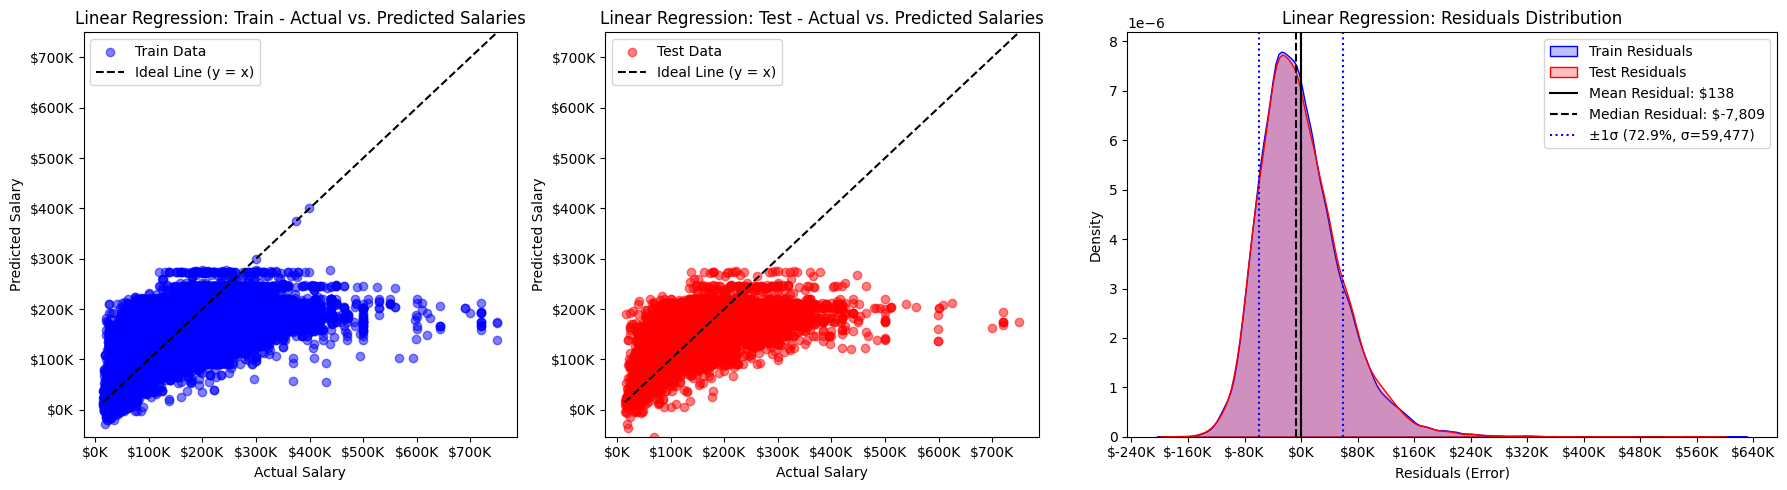

In [32]:
plot_regression_results(y_train, lr_y_pred_train, y_test, lr_y_pred_test, model_name="Linear Regression")

The plots indicate that the linear regression model does not capture the salary variations effectively, as the actual vs. predicted scatter plots show high dispersion around the ideal line. Additionally, the residual distributions for both train and test sets are nearly identical, suggesting that there is no significant overfitting. Since train and test errors are almost the same, applying regularization is unlikely to improve performance. The model might be missing key features or struggling with nonlinear relationships in the data.


random forest:

📊 Random Forest (Train) Performance:
MAE: 42,842.28
MAPE: 31.19%
RMSE: 57,166.75
RMSE / σ Ratio: 0.80
R²: 0.3564
--------------------------------------------------
📊 Random Forest (Test) Performance:
MAE: 44,734.03
MAPE: 32.86%
RMSE: 59,855.09
RMSE / σ Ratio: 0.83
R²: 0.3077
--------------------------------------------------


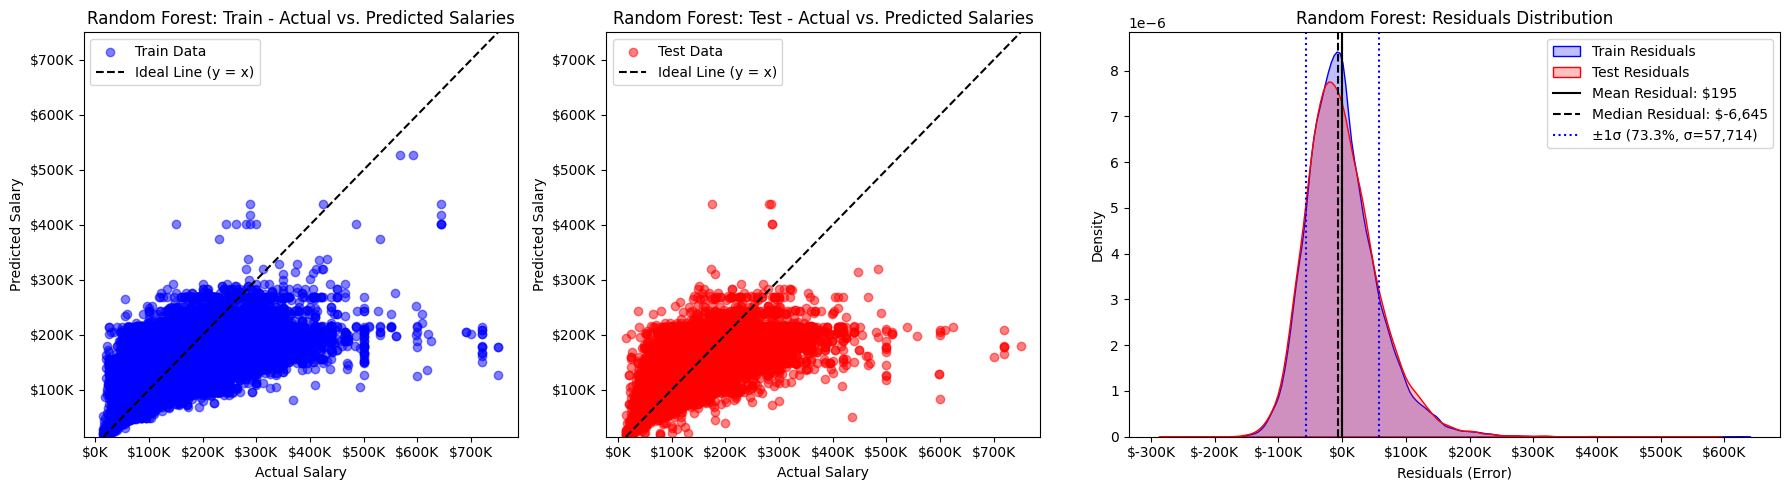

In [33]:

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_encoded, y_train)

# Predict on test data
rf_y_pred_train = rf_model.predict(X_train_encoded)
rf_y_pred_test = rf_model.predict(X_test_encoded)

# Evaluate model on training data
rf_train_results = evaluate_model("Random Forest (Train)", y_train, rf_y_pred_train)

# Evaluate model on test data
rf_test_results = evaluate_model("Random Forest (Test)", y_test, rf_y_pred_test)


plot_regression_results(y_train, rf_y_pred_train, y_test, rf_y_pred_test, model_name="Random Forest")


xgboost

📊 XGB (Train) Performance:
MAE: 43,925.35
MAPE: 32.79%
RMSE: 58,134.41
RMSE / σ Ratio: 0.82
R²: 0.3344
--------------------------------------------------
📊 XGB (Test) Performance:
MAE: 44,663.08
MAPE: 33.37%
RMSE: 59,624.04
RMSE / σ Ratio: 0.83
R²: 0.3130
--------------------------------------------------


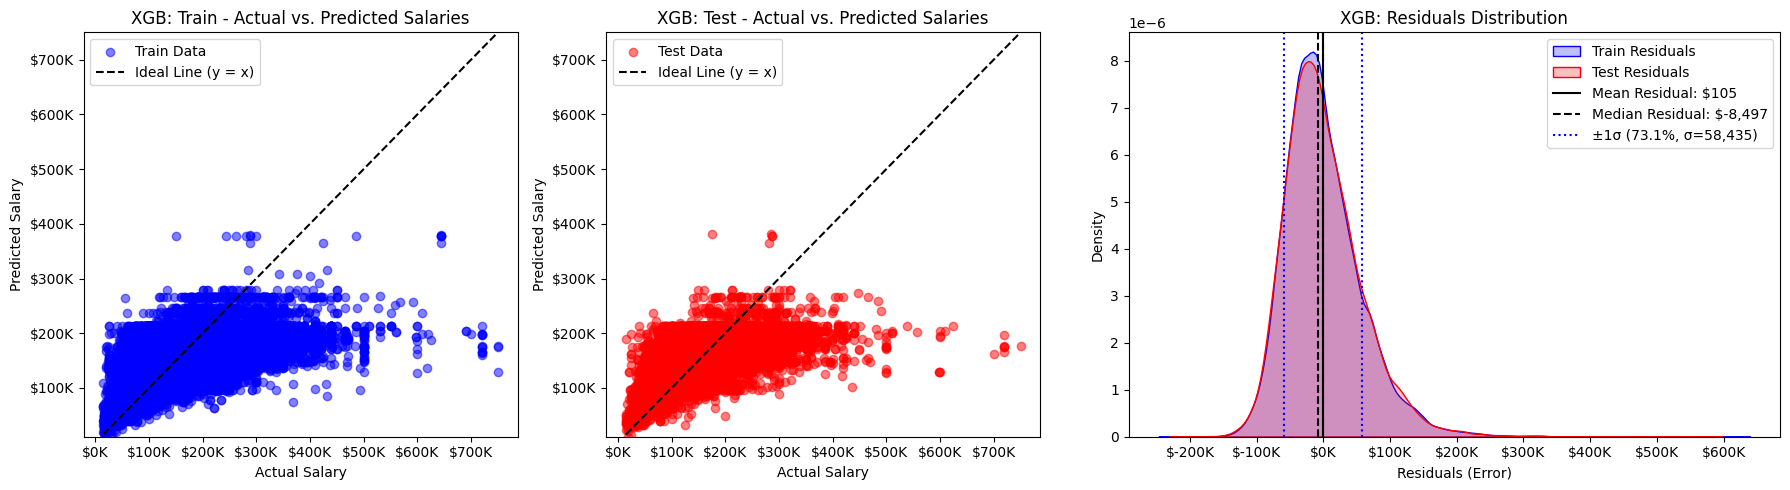

In [34]:
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_encoded, y_train)

xgb_y_pred_train = xgb_model.predict(X_train_encoded)
xgb_y_pred_test = xgb_model.predict(X_test_encoded)

# Evaluate model on training data
xgb_train_results = evaluate_model("XGB (Train)", y_train, xgb_y_pred_train)

# Evaluate model on test data
xgb_test_results = evaluate_model("XGB (Test)", y_test, xgb_y_pred_test)


plot_regression_results(y_train, xgb_y_pred_train, y_test, xgb_y_pred_test, model_name="XGB")


📊 XGB Categorized  (Train) Performance:
MAE: 43,000.57
MAPE: 31.40%
RMSE: 57,368.42
RMSE / σ Ratio: 0.81
R²: 0.3519
--------------------------------------------------
📊 XGB Categorized (Test) Performance:
MAE: 44,708.89
MAPE: 33.32%
RMSE: 59,659.07
RMSE / σ Ratio: 0.83
R²: 0.3122
--------------------------------------------------


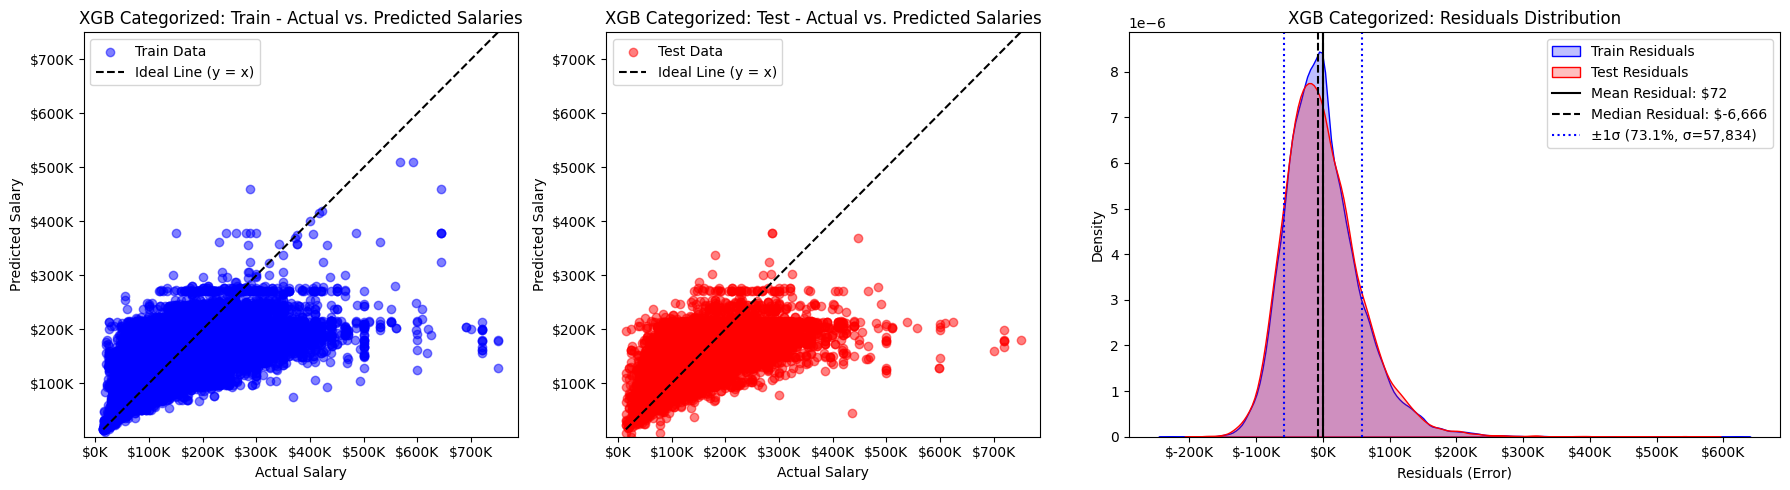

In [36]:
xgb_model_categorized = xgb.XGBRegressor(random_state=42, enable_categorical=True)
xgb_model_categorized.fit(X_train, y_train)

xgb_cat_y_pred_train = xgb_model_categorized.predict(X_train)
xgb_cat_y_pred_test = xgb_model_categorized.predict(X_test)

# Evaluate model on training data
xgb_cat_train_results = evaluate_model("XGB Categorized  (Train)", y_train, xgb_cat_y_pred_train)

# Evaluate model on test data
xgb_cat_test_results = evaluate_model("XGB Categorized (Test)", y_test, xgb_cat_y_pred_test)


plot_regression_results(y_train, xgb_cat_y_pred_train, y_test, xgb_cat_y_pred_test, model_name="XGB Categorized")


lgb

Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[62]	training's rmse: 58127	valid_1's rmse: 59449.9
📊 LGB (Train) Performance:
MAE: 43,837.52
MAPE: 32.52%
RMSE: 58,126.97
RMSE / σ Ratio: 0.82
R²: 0.3346
--------------------------------------------------
📊 LGB (Test) Performance:
MAE: 44,527.12
MAPE: 33.06%
RMSE: 59,449.94
RMSE / σ Ratio: 0.83
R²: 0.3170
--------------------------------------------------


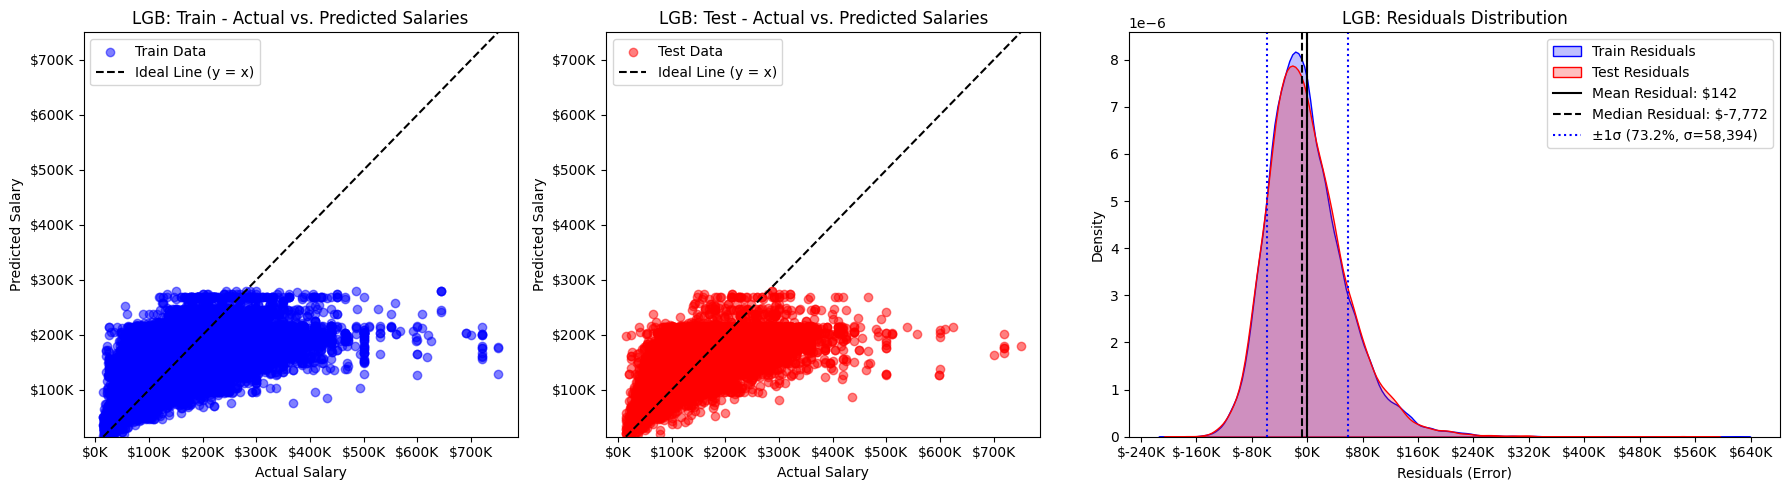

In [37]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, categorical_feature=categorical_columns)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 63,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.6,
    'verbose': -1
}

lgbm_model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=3),
        ]
)

lgb_y_pred_train = lgbm_model.predict(X_train, num_iteration=lgbm_model.best_iteration)
lgb_y_pred_test = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)

# Evaluate model on training data
lgb_train_results = evaluate_model("LGB (Train)", y_train, lgb_y_pred_train)

# Evaluate model on test data
lgb_test_results = evaluate_model("LGB (Test)", y_test, lgb_y_pred_test)


plot_regression_results(y_train, lgb_y_pred_train, y_test, lgb_y_pred_test, model_name="LGB")


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[68]	training's rmse: 58044.1	valid_1's rmse: 59428.1
📊 LGB (Train) Performance:
MAE: 43,793.71
MAPE: 32.46%
RMSE: 58,085.77
RMSE / σ Ratio: 0.82
R²: 0.3355
--------------------------------------------------
📊 LGB (Test) Performance:
MAE: 44,506.11
MAPE: 33.01%
RMSE: 59,434.58
RMSE / σ Ratio: 0.83
R²: 0.3174
--------------------------------------------------


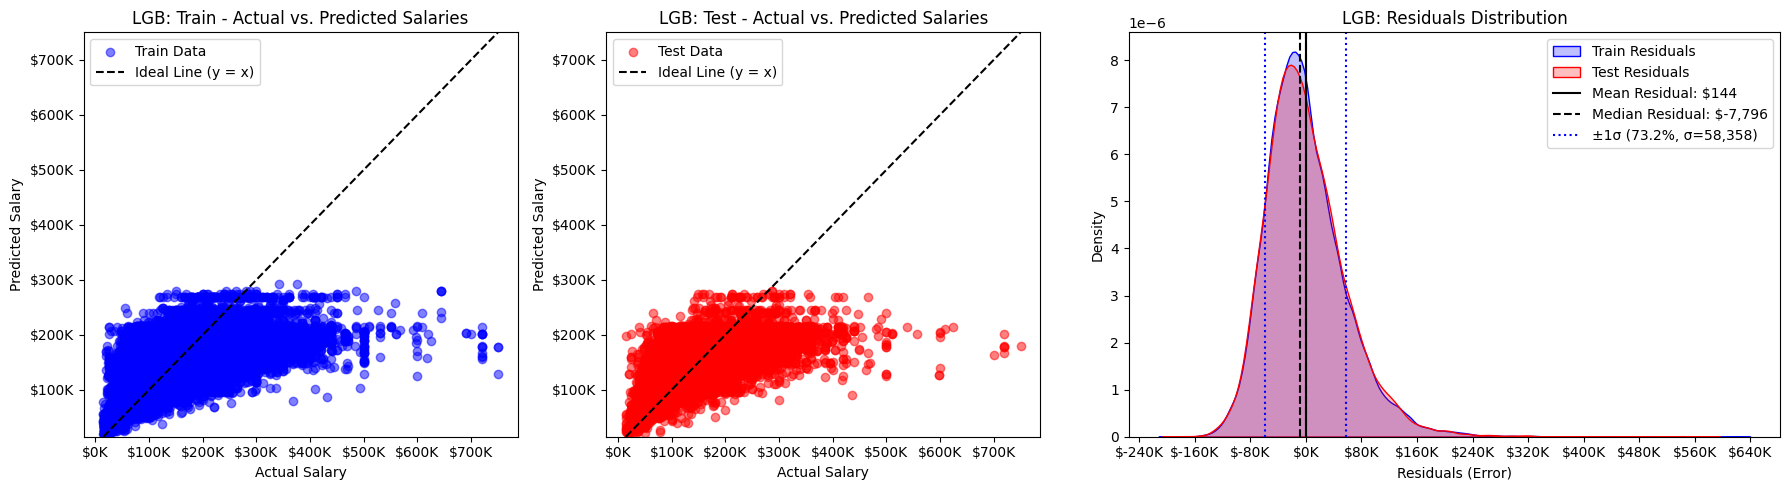

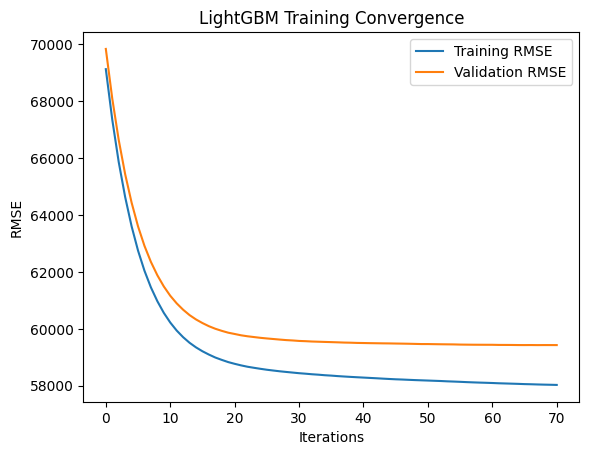

In [38]:
from lightgbm import LGBMRegressor
from lightgbm import early_stopping

LGBMRegressor_model = LGBMRegressor(
    objective='regression',
    metric='rmse',
    learning_rate=0.1,
    num_leaves=63,
    n_estimators=1000
)

LGBMRegressor_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=3)],
)


lgb_regression_y_pred_train = LGBMRegressor_model.predict(X_train, num_iteration=lgbm_model.best_iteration)
lgb_regression_y_pred_test = LGBMRegressor_model.predict(X_test, num_iteration=lgbm_model.best_iteration)

# Evaluate model on training data
lgb_regression_train_results = evaluate_model("LGB (Train)", y_train, lgb_regression_y_pred_train)

# Evaluate model on test data
lgb_regression_test_results = evaluate_model("LGB (Test)", y_test, lgb_regression_y_pred_test)


plot_regression_results(y_train, lgb_regression_y_pred_train, y_test, lgb_regression_y_pred_test, model_name="LGB")

plt.plot(LGBMRegressor_model.evals_result_['training']['rmse'], label='Training RMSE')
plt.plot(LGBMRegressor_model.evals_result_['valid_1']['rmse'], label='Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('LightGBM Training Convergence')
plt.legend()
plt.show()


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[186]	training's quantile: 11366.1	valid_1's quantile: 11666.1
📊 LGB (Train) Performance:
MAE: 81,767.04
MAPE: 71.98%
RMSE: 95,869.91
RMSE / σ Ratio: 1.35
R²: -0.8100
--------------------------------------------------
📊 LGB (Test) Performance:
MAE: 81,701.89
MAPE: 71.91%
RMSE: 95,882.76
RMSE / σ Ratio: 1.33
R²: -0.7766
--------------------------------------------------


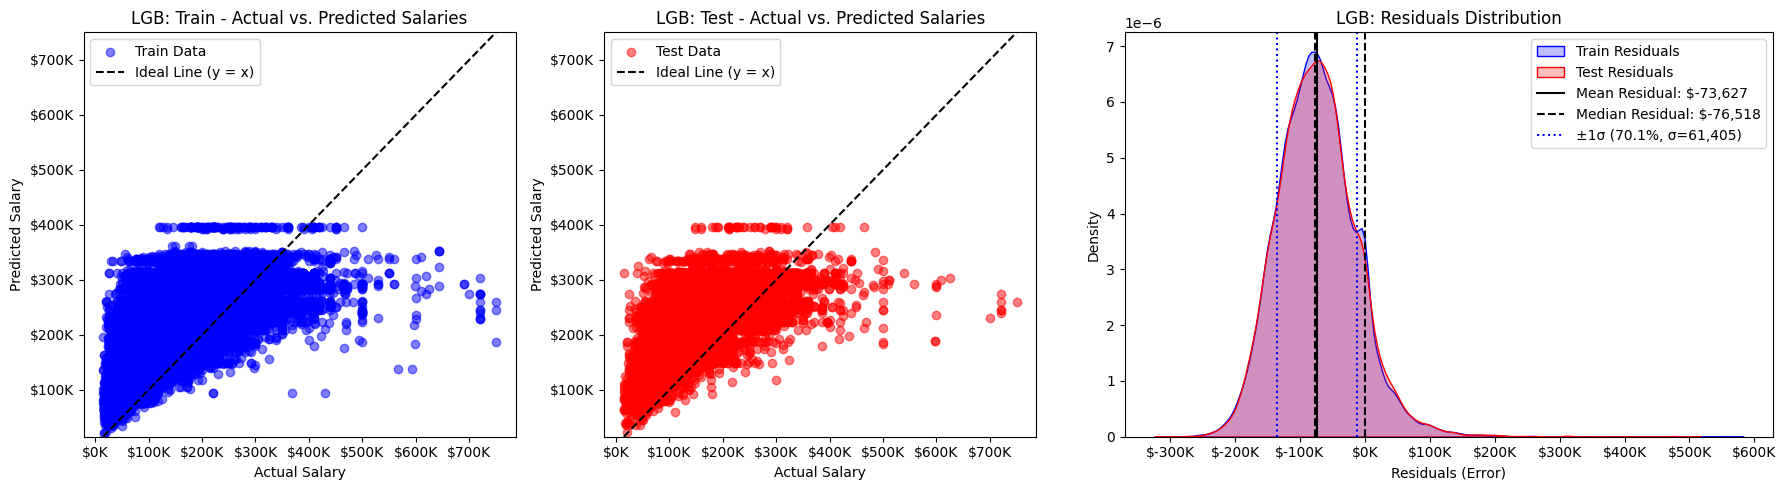

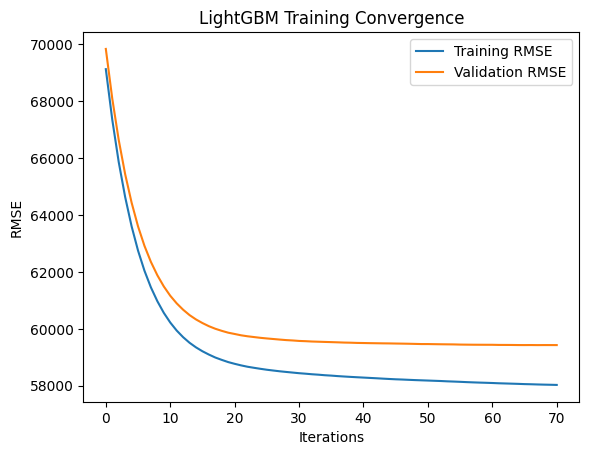

In [39]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, categorical_feature=categorical_columns)

params = {
    'objective': 'quantile',
    'metric': 'quantile',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'quantile_alpha': 0.5,  # q=0.5 (Median Prediction)
    'verbose': -1
}

lgbm_model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=3),
        ]
)

lgb_y_pred_train = lgbm_model.predict(X_train, num_iteration=lgbm_model.best_iteration)
lgb_y_pred_test = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)

# Evaluate model on training data
lgb_train_results = evaluate_model("LGB (Train)", y_train, lgb_y_pred_train)

# Evaluate model on test data
lgb_test_results = evaluate_model("LGB (Test)", y_test, lgb_y_pred_test)


plot_regression_results(y_train, lgb_y_pred_train, y_test, lgb_y_pred_test, model_name="LGB")
plt.plot(LGBMRegressor_model.evals_result_['training']['rmse'], label='Training RMSE')
plt.plot(LGBMRegressor_model.evals_result_['valid_1']['rmse'], label='Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('LightGBM Training Convergence')
plt.legend()
plt.show()


Can see its hard for LGB to improve

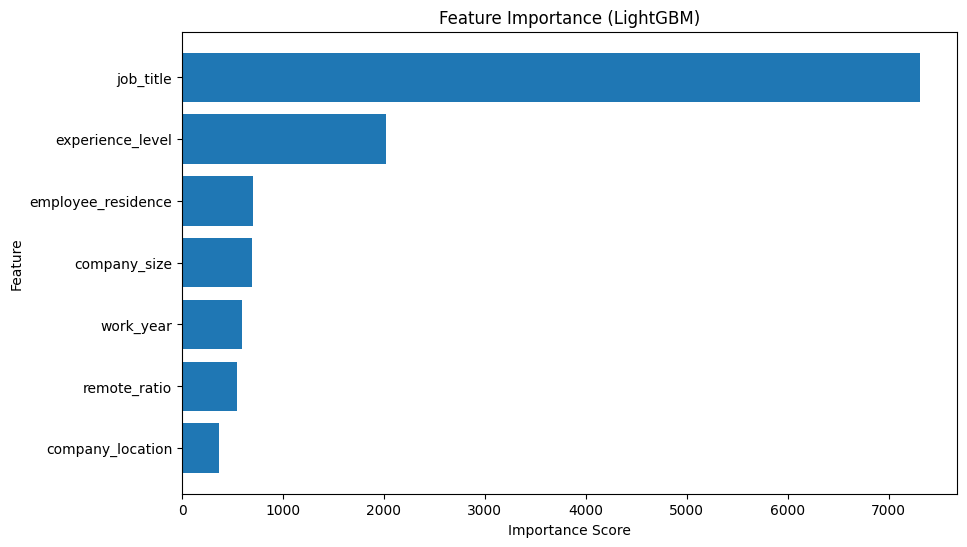

In [40]:
importance = lgbm_model.feature_importance(importance_type='gain')
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance (LightGBM)')
plt.gca().invert_yaxis()
plt.show()
